<header style="font-family:Arial Narrow;">
    <br>
    <aside style="float:left">
        <a href="https://www.usgs.gov/centers/cm-water">
            <img src="https://upload.wikimedia.org/wikipedia/commons/0/08/USGS_logo.png" alt="USGS" style="height: 80px;">
        </a>
    </aside>
     
    <aside style="float:right">
        <a href="https://www2.illinois.gov/epa/Pages/default.aspx"><img src="https://www2.illinois.gov/epa/Style%20Library/SOISierra/Images/SiteLogo.png" alt="Illinois EPA"  style="height: 80px;"></a>
    </aside>
    
   
    <div style="clear:both;">
        <hr style="background-color:black;">
        <h1 style="font-weight:bold; font-size:26pt" property="headline">Nitrate and Phosphorus Loads from Illinois Rivers</h1>
        <h2 style="font-weight:bold" property="alternativeHeadline">Water Year 2021 Update</h2>
        <address>
            <a property="author">Timothy O. Hodson<sup>1</sup></a>
            <br />  <sup>1</sup><a>U.S. Geological Survey Central Midwest Water Science Center</a>
        </address>
 
   </div>
   <br>
</header>

To help enable reproducible cutting-edge science, USGS will work to establish a community testbed for sharing data and workflows used in Illinois nutrient monitoring. This notebook demonstrates the basic concepts of
1. making all data available from the cloud in analysis ready formats;
2. running notebooks locally or in the cloud to generate reports, run models, or create interactive web applets; and
3. enabling anyone to share, run, and modify notebooks using only a web browser.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/thodson-usgs/rating-function-uncertainty/blob/master/notebooks/segmented_power_law_demo.ipynb)  


In [1]:
# TODO update functions that compute loads to adjust for missing sites

## Environment Setup

In [103]:
%%capture
#!pip install https://github.com/aleaf/Figures/archive/master.zip
#!pip install titlecase
    
import matplotlib.pyplot as plt
from Figures import ReportFigures

%matplotlib inline
rf = ReportFigures()
rf.set_style()

# configure fonts for presentation
import matplotlib.pyplot as plt


fig_w = 5.51181
fig_h = 4

In [104]:
# run for in-notebook presentation
SMALL_SIZE = 10
MEDIUM_SIZE = SMALL_SIZE + 2
BIGGER_SIZE = MEDIUM_SIZE + 2

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

save_figures = True
figure_count = 0
# set figure dimensions
#fig_w = 10
#fig_h = 8


In [105]:

# load libraries
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import json
import xarray as xr
import pint_xarray
from titlecase import titlecase

import warnings
warnings.filterwarnings("ignore", message="the unit of the quantity is stripped when downcasting to ndarray")

# load helper functions
from nmc import *
from nmc_plot import *

mass_unit = 'pound'
area_unit = 'acre'
flow_unit = 'cubic feet per second'
nested = True #subtract nested gages

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Datasets

In [106]:
supergage_metadata = '../../data/supergage_network.json'
ambient_metadata = '../../data/ambient_network.json'

with open(supergage_metadata) as f:
    supergage_network = json.load(f)
    
with open(ambient_metadata) as f:
    ambient_network = json.load(f)

supergage_ds = xr.load_dataset('../../data/illinois_supergage_annual_loads_continuous.nc').pint.quantify()#.pint.to(units=mass_unit)
#ambient_ds = xr.load_dataset('../../data/ambient_wrtdsk_annual_loads.netcdf')
ambient_ds = xr.load_dataset('../../data/illinois_ambient_annual_loads_wrtdsk.nc').pint.quantify()#.pint.to(units=mass_unit)

labels(ambient_network, nested=True)

['Rock at Joslin',
 'Rock at Rockton',
 'Green at Geneseo',
 'Illinois at Valley City',
 'Kaskaskia at Venedy Station',
 'Big Muddy at Murphysboro',
 'Little Wabash at Carmi',
 'Embarras at Ste. Mairie',
 'Vermilion at Danville']

In [107]:
ambient_network

[{'river': 'Rock',
  'location': 'at Joslin',
  'gage_id': '05446500',
  'iepa_id': 'P-04',
  'scale_factor': 1,
  'upstream_gage': '05437500'},
 {'river': 'Rock',
  'location': 'at Rockton',
  'gage_id': '05437500',
  'iepa_id': 'P-15',
  'scale_factor': 1,
  'nested': True},
 {'river': 'Green',
  'location': 'at Geneseo',
  'gage_id': '05447500',
  'iepa_id': 'PB-04',
  'scale_factor': 1},
 {'river': 'Illinois',
  'location': 'at Valley City',
  'gage_id': '05586100',
  'iepa_id': 'D-32',
  'scale_factor': 0.84},
 {'river': 'Kaskaskia',
  'location': 'at Venedy Station',
  'gage_id': '05594100',
  'iepa_id': 'O-20',
  'scale_factor': 1},
 {'river': 'Big Muddy',
  'location': 'at Murphysboro',
  'gage_id': '05599490',
  'iepa_id': 'N-12',
  'scale_factor': 1},
 {'river': 'Little Wabash',
  'location': 'at Carmi',
  'gage_id': '03381500',
  'iepa_id': 'C-23',
  'scale_factor': 1},
 {'river': 'Embarras',
  'location': 'at Ste. Mairie',
  'gage_id': '03345500',
  'iepa_id': 'BE-07',
  's

## Convert units

In [108]:
#ambient_ds.pint.to(units=mass_unit)
#
ambient_conversion = {}
for varname, da in ambient_ds.data_vars.items():
    if da.pint.units == 'kilogram':
        ambient_conversion[varname] = mass_unit
    elif da.pint.units == 'meter ** 3 / second':
        ambient_conversion[varname] = flow_unit

#ambient_conversion
ambient_ds = ambient_ds.pint.to(ambient_conversion)

supergage_ds = supergage_ds.pint.to({'nitrate nitrogen':mass_unit, 'total phosphorus':mass_unit})

ambient_ds

Magnitude,[[nan nan nan ... 227140750.55980328 162830909.7659645 107191954.83821741] [nan nan nan ... nan nan nan] [nan nan nan ... 379553173.8772414 303732075.0787761 133172055.69397032] ... [nan nan nan ... 204904389.35293376 240600326.5663397 434137509.2133935] [nan nan nan ... 85921921.68047272 72177348.28740615 89635609.23654866] [nan nan nan ... 389359842.05378056 354311148.73030156 317324792.94129217]]
Units,pound
Magnitude,[[nan nan nan ... nan nan nan] [nan nan nan ... nan nan nan] [nan nan nan ... 49498193.78575526 40768466.89462611 18686594.640028886] ... [nan nan nan ... nan nan nan] [nan nan nan ... nan nan nan] [nan nan nan ... nan nan nan]]
Units,pound
Magnitude,[[nan nan nan ... 8142014.624275977 7436713.562884666 4709721.0211009495] [nan nan nan ... nan nan nan] [nan nan nan ... 22763819.52809303 21127101.03567218 14238414.504194591] ... [nan nan nan ... 1040923.924712402 999153.6233292461 871740.6776485238] [nan nan nan ... 2949628.2091341177 2002100.2116944778 1992607.3932857378] [3170262.5641608564 3125706.5016327323 5695663.531553672 ... 8862552.890825743 6155437.711617592 5779614.172081422]]
Units,pound
Magnitude,[[nan nan nan ... nan nan nan] [nan nan nan ... nan nan nan] [nan nan nan ... 474020.98055573547 382357.4898316742 155188.96404716859] ... [nan nan nan ... 111440.9177561783 84953.32494239266 84880.41807228811] [nan nan nan ... 218315.7093228883 157234.58928552966 175707.73952833464] [nan nan nan ... 543124.9868687165 413836.32621509925 474994.850552711]]
Units,pound
Magnitude,[[nan nan nan ... 1750195.511445662 1186975.323240115 825948.5052625554] [nan nan nan ... nan nan nan] [nan nan nan ... 3308509.0474515697 2687102.055971532 1299009.8356372262] ... [nan nan nan ... 620138.187068711 650984.0322049509 658132.5431025218] [nan nan nan ... 2209771.54002833 1427767.2263314303 1408465.9316469543] [1949727.9242153035 2187545.681158614 3475530.7061271775 ... 6279526.218661923 4571273.983290327 4209877.053267011]]
Units,pound
Magnitude,[[nan nan nan ... 6946179.650244116 7094579.5671122065 4145026.006500065] [nan nan nan ... nan nan nan] [nan nan nan ... 17312690.775640693 17203235.473295107 12136388.29506766] ... [nan nan nan ... 361107.0001023165 340401.7576397945 260666.48784237704] [nan nan nan ... 794643.503372863 459346.703737543 470737.3053916229] [1241997.6332494305 945898.7151834145 2231635.2014475022 ... 2666604.7976071555 1697809.2687052912 1553697.1664668873]]


### Append ambient sites to supergages

In [109]:
#Add rock at rockton
rockton_id ='05437500'
rockton = ambient_ds.sel(site=rockton_id)[['nitrate nitrogen', 'total phosphorus']]
supergage_ds = xr.concat([supergage_ds, rockton], dim='site', join='inner')#sel(year.isin(supergage.year))

## Get drainage areas

In [110]:
# compute areas
from dataretrieval import nwis
site_df, _ = nwis.get_info(sites=gages(ambient_network, nested=True))
#(gages(ambient_network))
site_df = site_df[['site_no','dec_lat_va','dec_long_va','drain_area_va']]
#.rename({'site_no','site'}, axis=0)
site_ds = site_df.rename({'site_no':'site'}, axis=1).set_index('site').to_xarray()
site_ds = site_ds.pint.quantify({'drain_area_va':'square miles', 'dec_lat_va':'degrees', 'dec_long_va':'degrees'}).pint.to(drain_area_va=area_unit)

site_ds

Magnitude,[40.10087009 38.93643266 38.06055556 42.45027778 41.5561111 41.4889333 39.7033802 38.45055556 37.7583333]
Units,degree
Magnitude,[-87.5972419 -88.0225351 -88.1572222 -89.0725 -90.1852778 -90.1580083 -90.6454047 -89.6275 -89.3277778]
Units,degree
Magnitude,[825596.6976033025 970236.1190438811 1985272.0588879415 4072303.71073629 6111335.554584446 641917.4323225678 17115451.537988465 2811508.7539312467 1381754.4729655273]
Units,acre


In [9]:
#site_ds

In [112]:
network = compute_network_loads(site_ds, ambient_network, nested=nested)
network
#ambient_loads = ambient_loads.where(ambient_loads.year.dt.year >= baseline_years[0]).dropna(dim='year', how='all') # awkward

Magnitude,[-0.8941666799999979 41.4889333 33.350839367999995 38.45055556 37.7583333 38.06055556 38.93643266 37.293809183700006]
Units,degree
Magnitude,[-1.1127777999999893 -90.1580083 -76.142139948 -89.6275 -89.3277778 -88.1572222 -88.0225351 -81.46543496700001]
Units,degree
Magnitude,[2039031.8438481563 641917.4323225678 14376979.291910311 2811508.7539312467 1381754.4729655273 1985272.0588879415 970236.1190438811 767804.9287710714]
Units,acre


## Compute loads from monitoring network

In [113]:
## define study period
baseline_years = np.arange(1980,1996+1)
study_years = np.arange(2017,2021+1)
nested = True

# scale loads based on state's contributing drainage
# nested=False, so don't subtract off Rock at Rockton
supergage_loads = compute_network_loads(supergage_ds.dropna(dim='year'), supergage_network, nested=nested)

#ambient_loads = compute_network_loads(ambient_ds.sel(site=gages(ambient_network)).dropna(dim='year'),
ambient_loads = compute_network_loads(ambient_ds.sel(site=gages(ambient_network, nested=nested)),
                                      ambient_network, nested=nested)

ambient_loads = ambient_loads.where(ambient_loads.year.dt.year >= baseline_years[0]).dropna(dim='year', how='all') # awkward

# XXX don't need anything after this?
# compute baseline mean annual load
#baseline_mean_load = ambient_loads.sel(river=labels(ambient_network)).sum(dim='river').sel(year=ambient_loads.year.dt.year.isin(baseline_years)).mean()

# convert loads to percentages
#ambient_total_load_p = ambient_loads.sum(dim='river')/ baseline_mean_load * 100 - 100
#supergage_total_load_p = supergage_loads.sum(dim='river')/ baseline_mean_load * 100 - 100

## Methods
Replicates methods from previous biennial reports:
- baseline period: water years 1980–1996 
- current period: water years 2017–2022
- subtracts load for Rock River at Rockton
- rescales other rivers based on their drainage area within the State

but adds
- continuous water quality data


## Results
### Statewide Nitrate Load

In [114]:
supergage_total_yield = supergage_loads.sum(dim='river')/network['drain_area_va'].sum()
ambient_total_yield = ambient_loads.sum(dim='river')/network['drain_area_va'].sum()


baseline_mean_yield = ambient_total_yield.sel(year=ambient_loads.year.dt.year.isin(baseline_years)).mean()
#supergage_total_yield

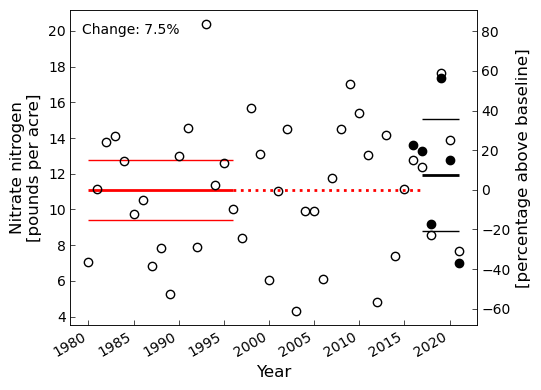

In [116]:
parameter='nitrate nitrogen'
loc='upper left'

fig, ax = plt.subplots(figsize=(fig_w, fig_h))


running_average_plot(ds1=ambient_total_yield[parameter],
                     period1=baseline_years,
                     period2=study_years,
                     ds2=supergage_total_yield[parameter], #comment this for ambient only
                     loc=loc,
                     ax=ax)

ax2 = percentage_scale(baseline_mean_yield[parameter].values, ax)

ax2.set_ylabel('[percentage above baseline]'.capitalize())


text = ax.set_ylabel(f'{parameter}\n[pounds per acre]'.capitalize())
fig.tight_layout()
str(figure_count).rjust(2,'0')

if save_figures:
    fig_str = str(figure_count).rjust(2,'0')
    fig.savefig(f'../../figures/{fig_str}_annual_{parameter}_load.png', dpi=150)
    figure_count += 1 

## Statewide Phosphorus Load

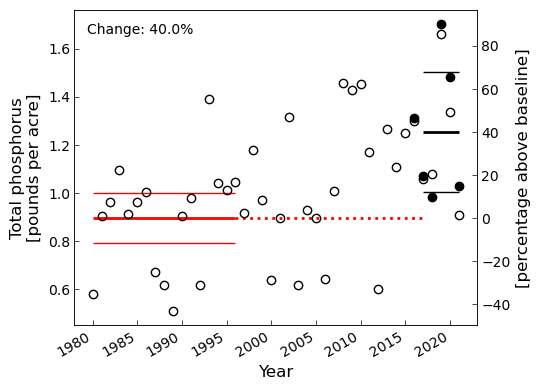

In [46]:
parameter='total phosphorus'
loc='upper left'

fig, ax = plt.subplots(figsize=(fig_w, fig_h))


running_average_plot(ds1=ambient_total_yield[parameter],
                     period1=baseline_years,
                     period2=study_years,
                     ds2=supergage_total_yield[parameter], #comment this for ambient only
                     loc=loc,
                     ax=ax)

ax2 = percentage_scale(baseline_mean_yield[parameter].values, ax)
#ax2 = ax.twiny()
#ax2.set_ylim()
ax2.set_ylabel('[percentage above baseline]'.capitalize())


text = ax.set_ylabel(f'{parameter}\n[pounds per acre]'.capitalize())
fig.tight_layout()
str(figure_count).rjust(2,'0')

if save_figures:
    fig_str = str(figure_count).rjust(2,'0')
    fig.savefig(f'../../figures/{fig_str}_annual_{parameter}_load.png', dpi=150)
    figure_count += 1 

## Breakdown by River

In [47]:
baseline_loads = ambient_loads.sel(year=ambient_loads.year.dt.year.isin(baseline_years))
current_loads = supergage_loads.sel(year=supergage_loads.year.dt.year.isin(study_years))

current_loads.groupby('river').mean(dim='year').to_dataframe()



,nitrate nitrogen,total phosphorus
river,,
Rock at Joslin,4.464994e+07,1.935197e+06
Green at Geneseo,1.159659e+07,5.145456e+05
Illinois at Valley City,1.915101e+08,1.707557e+07
Kaskaskia at Venedy Station,1.058507e+07,4.819653e+06
Big Muddy at Murphysboro,3.091539e+06,1.383331e+06
Little Wabash at Carmi,7.188931e+06,3.253963e+06
Embarras at Ste. Mairie,1.279583e+07,1.557913e+06
Vermilion at Danville,1.646005e+07,7.596918e+05


In [54]:
baseline_yields = baseline_loads/network['drain_area_va']
current_yields = current_loads/network['drain_area_va']
#ambient_total_yield = ambient_loads.sum(dim='river')/network['drain_area_va'].sum()
current_yields.groupby('river').mean(dim='year').to_dataframe()

,nitrate nitrogen,total phosphorus
river,,
Rock at Joslin,21.897617,0.949076
Green at Geneseo,18.065554,0.801576
Illinois at Valley City,13.320608,1.187702
Kaskaskia at Venedy Station,3.764908,1.714258
Big Muddy at Murphysboro,2.237401,1.001141
Little Wabash at Carmi,3.621132,1.639051
Embarras at Ste. Mairie,13.188366,1.605705
Vermilion at Danville,21.437804,0.989433


In [56]:
def statewide_yield(yeilds, drain_areas):
    
    current_yields*network['drain_area_va']

Magnitude,[[29.683031514326572 19.81695610178924 34.17440218772239 21.488340179181037 4.325353295043022] [16.456122843170284 12.40646455962407 35.172451197440566 15.217816406789986 11.074915038078077] [14.590638347993465 9.35571738899363 19.125944111004635 15.0514701083381 8.479270374107614] [2.473509186966403 3.6743121597487476 5.45225560193199 4.8008572878335745 2.423607528303634] [1.369294247213263 1.867876184905615 2.4792204362628203 2.5571123851095705 2.913502946993206] [2.587183013824624 2.6933890669909895 5.976893558900656 2.7106702243388243 4.137522212491056] [19.566468896910557 8.035141573550511 18.96581567061352 11.469262700504487 7.905141235723337] [23.104386765505012 27.145771776536467 22.47881651526051 20.369092128563516 14.090954392845077]]
Units,pound/acre
Magnitude,[[1.1261777390317957 0.5454721407288687 1.6927696421666036 1.0681882331415204 0.31277445937775905] [0.569423978893484 0.5061265365844974 1.8234092220418523 0.7112354439817603 0.3976850205359223] [1.1175773626702017 0.9987586642842848 1.5448286335700676 1.33676122047078 0.940585862230596] [1.129016706396403 1.1338847541138186 2.2681178511526294 2.340479735952382 1.6997932185138016] [0.7461206591479644 0.9225364848586346 1.3015521657299285 1.0516395621352383 0.9838547834696526] [0.8532225356180515 1.2480230210060987 2.2356183532366587 2.1740509695767183 1.6843419547844527] [1.4970212775246394 1.1303161308536855 2.044678265582092 2.0105953192066615 1.3459140935863552] [0.8523584246575651 0.9731343452210223 1.3865377756360195 1.0776495745029058 0.6574864779619282]]
Units,pound/acre


In [82]:
baseline_loads['nitrate nitrogen'].name#.pint.units

'nitrate nitrogen'

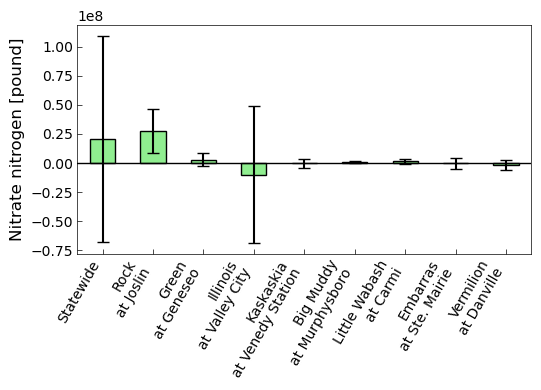

In [91]:
parameter = 'nitrate nitrogen'

fig, ax = plt.subplots(figsize=(fig_w, fig_h))

plot_change_by_basin(baseline_loads[parameter], 
                     current_loads[parameter], 
                     color='lightgreen',
                     mode='load',
                     da=network['drain_area_va'],
                     ax=ax)

ax.set_xticklabels([ label.get_text().replace(' at ','\nat ') for label in ax.get_xticklabels()], rotation=60, ha='right')
#text = ax.set_ylabel(titlecase(f'Change in {parameter} load\n[percentage above baseline]'))
fig.tight_layout()

if save_figures:
    fig_str = str(figure_count).rjust(2,'0')
    fig.savefig(f'../../figures/{fig_str}_{parameter}_basin_yield.png', dpi=150)
    figure_count += 1 

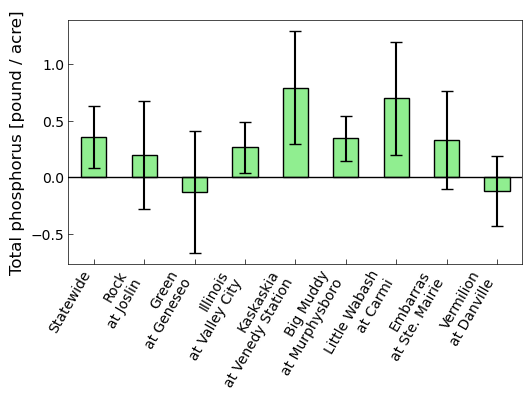

In [94]:
fig, ax = plt.subplots(figsize=(fig_w, fig_h))


plot_change_by_basin(baseline_loads[parameter], 
                     current_loads[parameter], 
                     color='lightgreen',
                     mode='yield',
                     da=network['drain_area_va'],
                     ax=ax)

ax.set_xticklabels([ label.get_text().replace(' at ','\nat ') for label in ax.get_xticklabels()], rotation=60, ha='right')
#text = ax.set_ylabel(titlecase(f'Change in {parameter} load\n[percentage above baseline]'))
fig.tight_layout()

if save_figures:
    fig_str = str(figure_count).rjust(2,'0')
    fig.savefig(f'../../figures/{fig_str}_{parameter}_basin_yield.png', dpi=150)
    figure_count += 1 

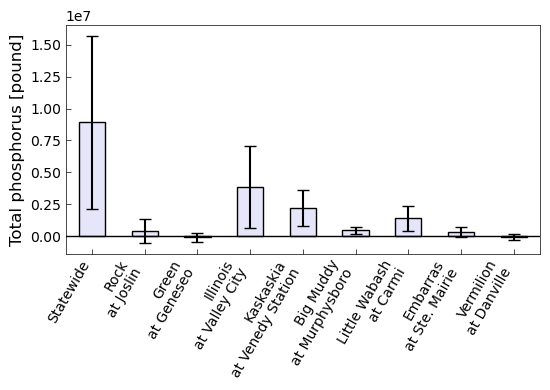

In [96]:
parameter = 'total phosphorus'

fig, ax = plt.subplots(figsize=(fig_w, fig_h))

plot_change_by_basin(baseline_loads[parameter], 
                     current_loads[parameter], 
                     color='lavender',
                     mode='load',
                     da=network['drain_area_va'],
                     ax=ax)

ax.set_xticklabels([ label.get_text().replace(' at ','\nat ') for label in ax.get_xticklabels()], rotation=60, ha='right')
#text = ax.set_ylabel(titlecase(f'Change in {parameter} load\n[percentage above baseline]'))
fig.tight_layout()

if save_figures:
    fig_str = str(figure_count).rjust(2,'0')
    fig.savefig(f'../../figures/{fig_str}_{parameter}_basin_load.png', dpi=150)
    figure_count += 1 

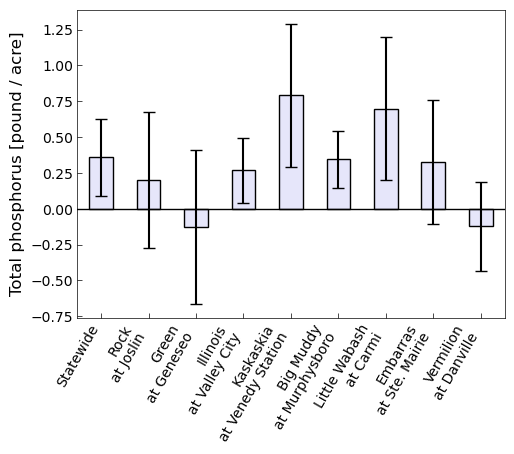

In [97]:
pfig, ax = plt.subplots(figsize=(fig_w, fig_h))

plot_change_by_basin(baseline_loads[parameter], 
                     current_loads[parameter], 
                     color='lavender',
                     mode='yield',
                     da=network['drain_area_va'],
                     ax=ax)

ax.set_xticklabels([ label.get_text().replace(' at ','\nat ') for label in ax.get_xticklabels()], rotation=60, ha='right')
#text = ax.set_ylabel(titlecase(f'Change in {parameter} load\n[percentage above baseline]'))
fig.tight_layout()

if save_figures:
    fig_str = str(figure_count).rjust(2,'0')
    fig.savefig(f'../../figures/{fig_str}_{parameter}_basin_yield.png', dpi=150)
    figure_count += 1 

## Streamflow
Download streamflow data from NWIS (U.S. Geological Survey, 2022)

In [18]:
# download flow data 
from dataretrieval import nwis
# begin by downloading flow datga
ambient_gages = gages(ambient_network)
supergage_gages = gages(supergage_network)


start = ambient_loads.year.dt.strftime('%Y')[0] + '-10-01'
start = str(start.values)
end = '2021-09-30'

df, _ = nwis.get_dv(sites=ambient_gages, start=start, end=end, parameterCd='00060')
df = df.rename({'00060_Mean':'mean flow [cfs]'}, axis=1).drop('00060_Mean_cd', axis=1)

#remove timezone because xarray doesn't know how to handle it yet (bug)
df = df.reset_index()
df['datetime'] = df['datetime'].values
df = df.set_index(['site_no','datetime'])

flow_ds = df.to_xarray()
flow_ds['water_year'] = flow_ds.datetime.dt.year.where(flow_ds.datetime.dt.month < 10, flow_ds.datetime.dt.year + 1)

# compute mean daily flow for each WY
# TODO make correction for missing periods
flow_wy = flow_ds.groupby('water_year').mean()#.pint.quantify({'flow': 'cfs'})
flow_wy['water_year'] = pd.to_datetime(flow_wy['water_year'], format='%Y').values
flow_wy = flow_wy.rename({'water_year':'year'})


# scale to ambient sites
ambient_streamflow = compute_network_loads(flow_wy, ambient_network, nested=False)

ModuleNotFoundError: No module named 'dataretrieval'

Timeseries of annual streamflow

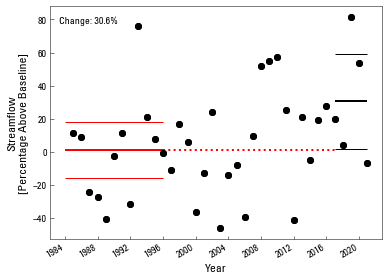

In [98]:
# plot streamflow
parameter='mean flow [cfs]'
statewide_streamflow = ambient_streamflow[parameter].groupby('year').sum(dim='river')
baseline_streamflow = statewide_streamflow.sel(year=ambient_loads.year.dt.year.isin(baseline_years)).mean()

statewide_streamflow_p = statewide_streamflow / baseline_streamflow * 100 - 100

fig, ax = plt.subplots(figsize=(fig_w, fig_h))

running_average_plot(ds1=statewide_streamflow_p,
                     period1=baseline_years,
                     period2=study_years,
                     loc='upper left',
                     ax=ax)


text = ax.set_ylabel(titlecase(f'Streamflow\n[percentage above baseline]'))
fig.tight_layout()

if save_figures:
    fig_str = str(figure_count).rjust(2,'0')
    fig.savefig(f'../../figures/{fig_str}_annual_streamflow.png', dpi=150)
    figure_count += 1 

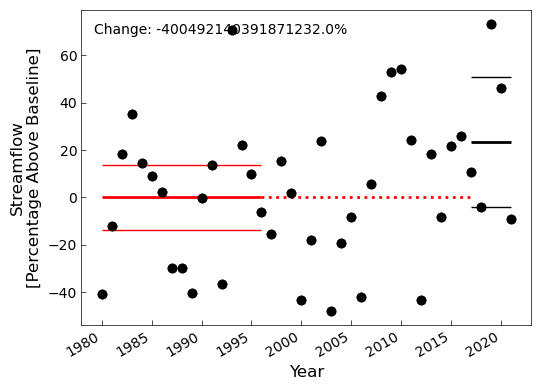

In [102]:
# plot streamflow
mean_flow = ambient_loads['mean flow']
statewide_streamflow = mean_flow.groupby('year').sum(dim='river')
baseline_streamflow = statewide_streamflow.sel(year=ambient_loads.year.dt.year.isin(baseline_years)).mean()

statewide_streamflow_p = statewide_streamflow / baseline_streamflow * 100 - 100

fig, ax = plt.subplots(figsize=(fig_w, fig_h))

running_average_plot(ds1=statewide_streamflow_p,
                     period1=baseline_years,
                     period2=study_years,
                     loc='upper left',
                     ax=ax)


text = ax.set_ylabel(titlecase(f'Streamflow\n[percentage above baseline]'))
fig.tight_layout()

if save_figures:
    fig_str = str(figure_count).rjust(2,'0')
    fig.savefig(f'../../figures/{fig_str}_annual_streamflow.png', dpi=150)
    figure_count += 1 

Change in streamflow yields by basin.

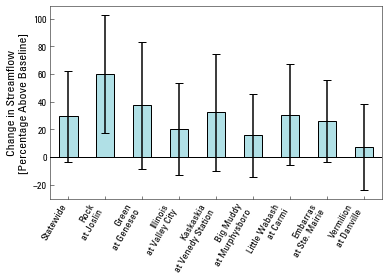

In [69]:
# select streamflow for baseline and current timeperiods
baseline_streamflow = ambient_streamflow.sel(year=ambient_streamflow.year.dt.year.isin(baseline_years))
current_streamflow = ambient_streamflow.sel(year=ambient_streamflow.year.dt.year.isin(study_years))

fig, ax = plt.subplots(figsize=(fig_w, fig_h))

plot_change_by_basin(baseline_streamflow[parameter], 
                     current_streamflow[parameter], 
                     color='powderblue',
                     ax=ax,
                     statewide=False)

ax.set_xticklabels([ label.get_text().replace(' at ','\nat ') for label in ax.get_xticklabels()], rotation=60, ha='right')
text = ax.set_ylabel(titlecase(f'Change in Streamflow\n[percentage above baseline]'))
fig.tight_layout()

if save_figures:
    fig_str = str(figure_count).rjust(2,'0')
    fig.savefig(f'../../figures/{fig_str}_streamflow_basin.png', dpi=150)
    figure_count += 1 

## Flow-adjusted loads
Flow-adjusted nitrate loads by basin.

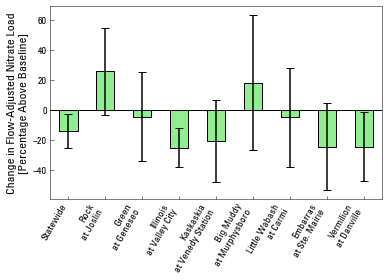

In [99]:
parameter = 'nitrate'
fig, ax = plt.subplots(figsize=(fig_w, fig_h))

total_streamflow = ambient_streamflow.sum(dim='river')['mean flow [cfs]']

plot_change_by_basin(baseline_loads[parameter] / total_streamflow, 
                     current_loads[parameter] / total_streamflow, 
                     color='lightgreen', 
                     ax=ax, 
                     statewide=False)

ax.set_xticklabels([ label.get_text().replace(' at ','\nat ') for label in ax.get_xticklabels()], rotation=60, ha='right')

text = ax.set_ylabel(titlecase(f'Change in flow-adjusted {parameter} load\n[percentage above baseline]'))
fig.tight_layout()

if save_figures:
    fig_str = str(figure_count).rjust(2,'0')
    fig.savefig(f'../../figures/{fig_str}_{parameter}_basin_fa_yield.png', dpi=150)
    figure_count += 1 

Flow-adjusted phosphorus load by basin

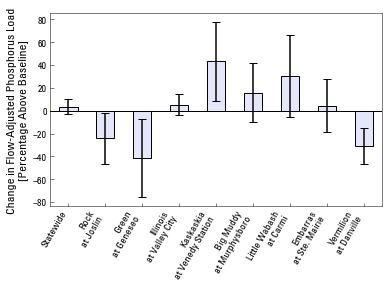

In [101]:
parameter = 'phosphorus'
fig, ax = plt.subplots(figsize=(fig_w, fig_h))

plot_change_by_basin(baseline_loads[parameter] / total_streamflow, 
                     current_loads[parameter] / total_streamflow, 
                     color='lavender', 
                     ax=ax, 
                     statewide=False)

ax.set_xticklabels([ label.get_text().replace(' at ','\nat ') for label in ax.get_xticklabels()], rotation=60, ha='right')
text = ax.set_ylabel(titlecase(f'Change in flow-adjusted {parameter} load\n[percentage above baseline]'))
fig.tight_layout()

if save_figures:
    fig_str = str(figure_count).rjust(2,'0')
    fig.savefig(f'../../figures/{fig_str}_{parameter}_basin_fa_yield.png', dpi=150)
    figure_count += 1 

## Summary
1. Nitrate load increased 10%, primarily from the Rock River
1. Phosphorus load increased 30%, primarily from the Illinois, Kaskaskia, and Little Wabash
1. Streamflow increased 30%
1. Adjusting for streamflow, nitrate loads have declined 10%.
1. Adjusting for streamflow, phosphorus is approximately at the baseline load.


## References
U.S. Geological Survey, 2022, National Water Information System data available on the World Wide Web (USGS Water Data for the Nation), accessed [July 25, 2022], at URL [http://waterdata.usgs.gov/nwis/].